<a href="https://colab.research.google.com/github/prasanth30/WOC-5.0/blob/main/L_layer_Neural_Network_Image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(12) #to get stable results
from google.colab import drive
drive.mount('/content/drive')
classifier_train = pd.read_csv("/content/drive/My Drive/WOC/classification_train.csv")
classifier_train.head()

Mounted at /content/drive


,Unnamed: 0,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,0,0,0,0,0,0,0,0,...,70,27,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,35,0,0,0,0,0,0,0,0,0
3,3,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2,0,0,0,0,1,0,3,0,...,2,0,0,91,117,7,0,0,0,0


# Data Analysis

In [15]:
#classifier_train.groupby('label')
"""for i,g in classifier_train.groupby('label'):
    print(g)"""

"for i,g in classifier_train.groupby('label'):\n    print(g)"

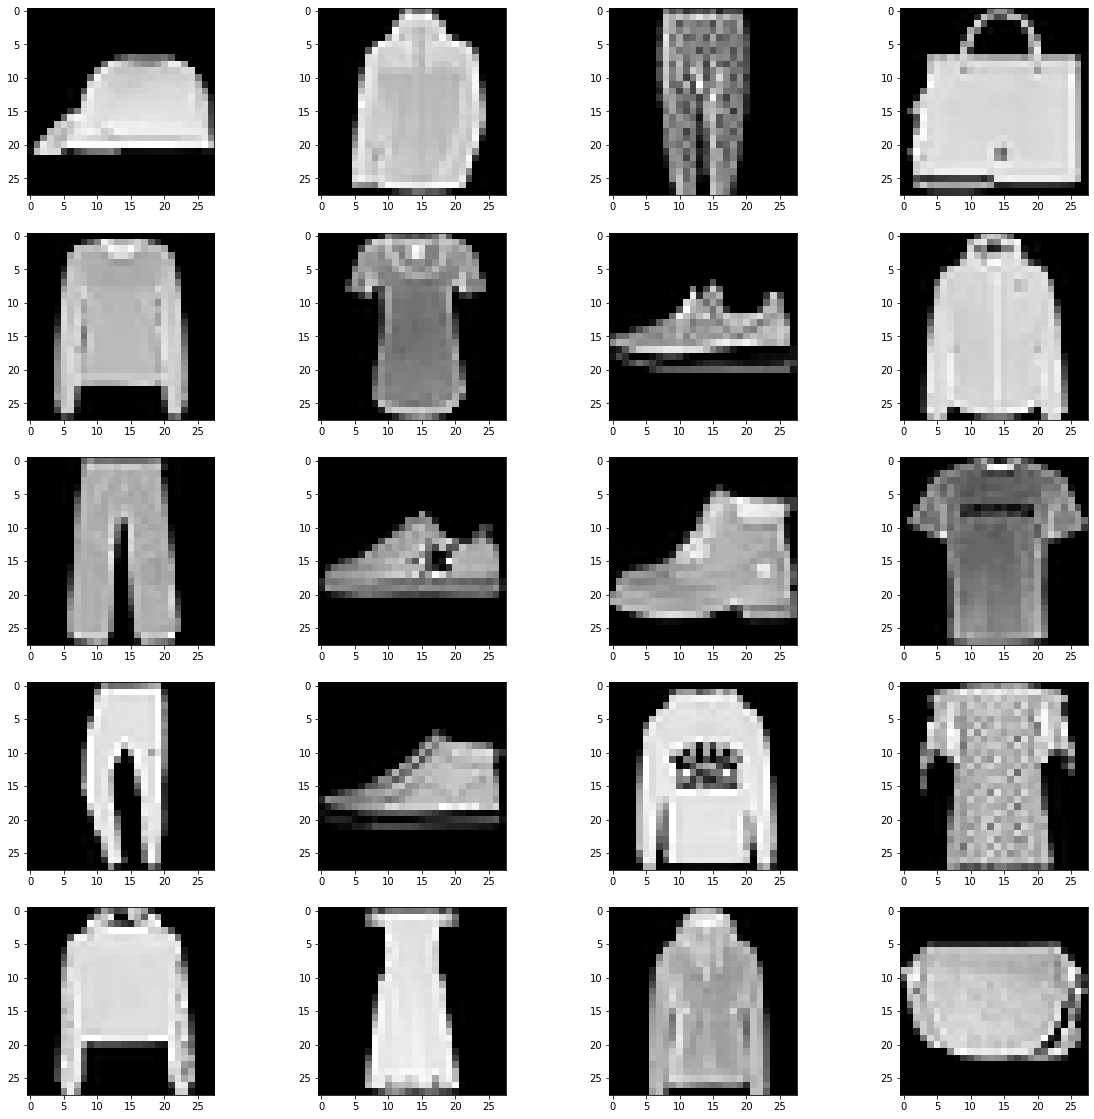

In [16]:
plt.figure(figsize=(20,20))
plots = []
for i in range(20):
    ax = plt.subplot2grid((5,4), (i//4,i%4))
    image1 = classifier_train[:][i:i+1]#.to_numpy()
    #image1.reshape((28,28))
    image1 = image1.iloc[:,2:].to_numpy().reshape((28,28))
    ax.imshow(image1,cmap='gray')

In [17]:
#RANDOM SPLIT
"""ratio_train = 0.60
ratio_cv = 0.20
classifier_train = classifier_train.sample(frac=1) #shuffle
total_rows = classifier_train.shape[0]
total_train = int(total_rows*ratio_train)
total_cv = int(total_rows*ratio_cv)
X_train = classifier_train.iloc[:total_train,2:].to_numpy()
X_cv = classifier_train.iloc[total_train:total_train+total_cv,2:].to_numpy()
X_test = classifier_train.iloc[total_train+total_cv:,2:].to_numpy()
Y_train = classifier_train.iloc[:total_train,1:2].to_numpy().reshape((total_train,))
Y_cv = classifier_train.iloc[total_train:total_train+total_cv,1:2].to_numpy().reshape((total_cv,))
Y_test = classifier_train.iloc[total_train+total_cv:,1:2].to_numpy().reshape((total_rows-total_train-total_cv,))
X_train=X_train.T
X_train.shape"""

'ratio_train = 0.60\nratio_cv = 0.20\nclassifier_train = classifier_train.sample(frac=1) #shuffle\ntotal_rows = classifier_train.shape[0]\ntotal_train = int(total_rows*ratio_train)\ntotal_cv = int(total_rows*ratio_cv)\nX_train = classifier_train.iloc[:total_train,2:].to_numpy()\nX_cv = classifier_train.iloc[total_train:total_train+total_cv,2:].to_numpy()\nX_test = classifier_train.iloc[total_train+total_cv:,2:].to_numpy()\nY_train = classifier_train.iloc[:total_train,1:2].to_numpy().reshape((total_train,))\nY_cv = classifier_train.iloc[total_train:total_train+total_cv,1:2].to_numpy().reshape((total_cv,))\nY_test = classifier_train.iloc[total_train+total_cv:,1:2].to_numpy().reshape((total_rows-total_train-total_cv,))\nX_train=X_train.T\nX_train.shape'

In [2]:
#stratified split
ratio_train=0.8
ratio_cv = 0.1
ratio_test=0.1
total_rows = classifier_train.shape[0]
total_train = int(total_rows*ratio_train)
total_cv = int(total_rows*ratio_cv)
shuffled_df = classifier_train.sample(frac=1,random_state=12)
grped_df = shuffled_df.groupby('label')
ans = [np.split(df_label,[int(ratio_train*len(df_label)),int((ratio_train+ratio_cv)*len(df_label))])for label,df_label in grped_df]
df_train = pd.concat([x[0] for x in ans]).sample(frac=1,random_state=12)
df_cv = pd.concat([x[1] for x in ans]).sample(frac=1,random_state=12)
df_test = pd.concat([x[2] for x in ans]).sample(frac=1,random_state=12)
#df_train
X_train = df_train.iloc[:,2:].to_numpy().T
X_cv = df_cv.iloc[:,2:].to_numpy().T
X_test = df_test.iloc[:,2:].to_numpy().T
Y_train = df_train.iloc[:,1:2].to_numpy().reshape((total_train,))
Y_cv = df_cv.iloc[:,1:2].to_numpy().reshape((total_cv,))
Y_test = df_test.iloc[:,1:2].to_numpy().reshape((total_rows-total_train-total_cv,))
X_train=X_train/256.0
X_cv=X_cv/256.0
X_test=X_test/256.0

In [19]:
X_train.shape

(784, 24000)

# MODEL

In [3]:
class NNeuralnetwork:
#initialize all the parameters and hyperparameters involved
      def __init__(self,layer_sizes,activation):
          self.layer_sizes = layer_sizes #define the architecture
          self.num_layers = len(layer_sizes)
          self.activation = activation
          self.params = {} #stores all weights,biases of the model
          self.activations = {} #stores activations of all layers
          self.lr = None #learning rate (hyperparameter)
          self.epochs = None #no of epochs
          for i in range(1,self.num_layers):
            input_layer = layer_sizes[i-1]
            output_layer = layer_sizes[i]
            #Xavier initialization of weights
            self.params[f"W{i}"] = np.random.randn(output_layer,input_layer)*np.sqrt(1/(input_layer+output_layer))
            self.params[f"b{i}"] = np.zeros((output_layer,1))
      def sigmoid(self,X):
        return 1/(1+np.exp(-X))
      def tanh(self,X):
        return (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
      def forward_prop(self,X): #X is the input layer activations
          self.activations={"A0":X}  #stores activations before and after applying activation function
          for i in range(1,self.num_layers):
              W_i = self.params[f"W{i}"]
              b_i = self.params[f"b{i}"]
              Z_i = np.dot(W_i,self.activations[f"A{i-1}"])+b_i #W_i (li,li-1) (li-1,m)-> (li,m)
              if self.activation=='ReLU':
                A_i = Z_i*(Z_i > 0)
              elif self.activation=='leaky ReLU':
                A_i = Z_i*(Z_i > 0) + Z_i*0.01*(Z_i < 0)#ReLU
              elif self.activation=='sigmoid':
                A_i = self.sigmoid(Z_i)
              else:
                A_i = self.tanh(Z_i)
              #implementing leaky ReLU
              #store them in the activations dictionary to use it for next layer and backpropagation
              self.activations[f"Z{i}"] = Z_i
              self.activations[f"A{i}"] = A_i
          #final output softmax layer
          Z_f = self.activations[f"Z{self.num_layers-1}"]
          #print(Z_f)
          #softmax function
          #normal softmax implementation
          #exp_score = np.exp(Z_f)
          #output_probs = exp_score/(np.sum(exp_score,axis=0,keepdims=True))
          #but to add numerical stability a constant is multiplied to both numerator and denominator and a popular choice is max(z)
          exp_score = np.exp(Z_f- np.max(Z_f,axis=0,keepdims=True))
          output_probs = exp_score/(np.sum(exp_score,axis=0,keepdims=True))
          return output_probs #(10,m)
      def back_prop(self,X,Y):
          m = Y.shape[0]
          grads = {}
          probs = self.forward_prop(X)
          delta = probs.copy()
          #gradient of the output layer
          #dYh = Yh-Y
          delta[Y,range(m)] -=1
          
          for i in range(self.num_layers-1,0,-1):
            W_i = self.params[f"W{i}"]
            b_i = self.params[f"b{i}"]
            Z_i = self.activations[f"Z{i}"]
            #using weights,biases,activations of this layer,find out the gradients of previous layer
            #check activation
            if self.activation=='ReLU':
              delta = delta * (Z_i > 0)
            elif self.activation=='leaky ReLU':
              delta = delta * (Z_i > 0) + delta *0.01*(Z_i < 0)
            elif self.activation=='sigmoid':
              delta = delta*self.sigmoid(Z_i)*(1-self.sigmoid(Z_i))
            else: #tanh
              delta = delta*(1-np.power(self.tanh(Z_i),2))
            #obtain activations of previous layer
            A_prev = self.activations[f"A{i-1}"]
            #calculate gradients
            dW = (1/m)*(delta.dot(A_prev.T))
            db = (1/m)*np.sum(delta,axis=1)
            dA_prev = np.dot(W_i.T,delta)
            delta = dA_prev 
            grads[f"dW{i}"] = dW
            grads[f"db{i}"] = db
          self.grads = grads
      def train(self,X,Y,X_cv,Y_cv,learning_rate=0.0001,epochs=16,batch_size = 32, beta1=0.9, beta2 = 0.999,epsilon = 1e-8,show_epochs=True):
          self.lr = learning_rate
          self.epochs = epochs
          num_batches = int(np.ceil(X.shape[0]/batch_size))
          #Initialization of ADAM OPTIMISATION
          v = {}
          s = {}
          shat = {} #implemented amsgrad optimisation
          for key,value in self.params.items():
            v[key] = np.zeros_like(value)
            s[key] = np.zeros_like(value)
            shat[key] = np.zeros_like(value) #amsgrad optimisation
          #print(v['b1'].shape)
          losses=[]
          accuracies = []
          accuracies1 = []
          for epoch in range(self.epochs):

              if num_batches>3:
                #shuffle data by generating random permutation,and using that order.
                perm = np.random.permutation(X.shape[1]) 
                X = X[:,perm]
                Y = Y[perm]
              #BATCH GRADIENT DESCENT
              for batch in range(num_batches):
                X_batch = X[:,batch*(batch_size):(batch+1)*(batch_size)]
                Y_batch = Y[batch*(batch_size):(batch+1)*(batch_size)]

                #forward pass

                probs = self.forward_prop(X_batch)
                #calculating cost using
                #sparse categorical cross entropy function
                loss = -np.mean(np.log(probs[Y_batch,np.arange(len(Y_batch))]))
                losses.append(loss)
                #backward pass
                self.back_prop(X_batch,Y_batch)
                
                #update params using Adam optimization

                for key in self.params.keys():
                    #Gradients momentum
                    #print(v[key].shape)
                    v[key] = beta1*v[key] + (1-beta1)*self.grads[f"d{key}"].reshape(v[key].shape)
                    
                    v_corr = v[key]/(1-np.power(beta1,epoch+1))
                    #RMSprop
                    s[key] = beta2*s[key] + (1-beta2)*np.power(self.grads[f"d{key}"].reshape(s[key].shape),2)
                    s_corr = s[key]/(1-np.power(beta2,epoch+1))
                    shat[key] = np.maximum(shat[key],s_corr)
                    #adding amsgrad optimization


                    """if epoch==0:
                      print(key)
                      print(v[key].shape)
                      print(s_corr.shape)
                    """#update parameters 
                    self.params[key] -= self.lr*v_corr/(np.sqrt(shat[key])+epsilon)
              #accuracy on training set
              acc = self.accuracy(X,Y)
              #accuracy on cross validation test
              acc1 = self.accuracy(X_cv,Y_cv)
              accuracies.append(acc*100)
              #accuracies1.append(acc1*100)
              if show_epochs==True:
                print(f"Epoch {epoch}/{self.epochs}=> \n loss={loss} accuracy={acc} validation accuracy = {acc1}")
          if show_epochs==False:
              print(f"final accuracy for {self.activation} ==> {self.accuracy(X_cv,Y_cv)}")
          else:
            plt.plot(np.arange(epochs*num_batches),losses,'r')
          self.losses=losses
          #plt.plot(np.arange(epochs),accuracies,'g')
          #plt.plot(np.arange(epochs),accuracies1,'g',linestyle='-')
      def predict(self,X):
          probs = self.forward_prop(X)
          return np.argmax(probs,axis=0)
      def accuracy(self,X,Y):
          Y_pred = self.predict(X)
          return np.mean(Y_pred == Y)
      def confusion_matrix(self,X,Y_test,Y_pred):
          conf_matrix = np.zeros((10,10))
          n = Y_test.shape[0]  
          for i in range(n):
            conf_matrix[Y_test[i]][Y_pred[i]]+=1
          fig, ax = plt.subplots(figsize=(7.5, 7.5))
          ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
          for i in range(conf_matrix.shape[0]):
              for j in range(conf_matrix.shape[1]):
                  ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
          
          plt.xlabel('Predictions', fontsize=18)
          plt.ylabel('Actuals', fontsize=18)
          plt.title('Confusion Matrix', fontsize=18)
          plt.show()
      def wrongly_classified_examples(self,X,Y,Y_pred):
          plt.figure(figsize=(20,20))
          plots = []
          j = 0
          class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
          for i in range(Y.shape[0]):
            if Y_pred[i] != Y[i]:
                if j==20:
                  break
                ax = plt.subplot2grid((5,4), (j//4,j%4))
                j+=1
                image1 = X[:,i:i+1].reshape((28,28))*256
                ax.title.set_text("Classified "+class_names[Y_pred[i]]+" instead of "+class_names[Y[i]])
                ax.imshow(image1,cmap='gray')
      def complete_test(self,X,Y):
          Y_pred = self.predict(X)
          self.confusion_matrix(X,Y,Y_pred)
          self.wrongly_classified_examples(X,Y,Y_pred)
      def return_losses(self):
          return self.losses

In [ ]:
"""ans = model.forward_prop(X_train)
model.back_prop(X_train,Y_train)"""

'ans = model.forward_prop(X_train)\nmodel.back_prop(X_train,Y_train)'

In [ ]:
"""model.grads['dW1'].shape"""

"model.grads['dW1'].shape"

In [ ]:
"""model.grads['db1'].shape"""

"model.grads['db1'].shape"

# Finding best activation function

final accuracy for ReLU ==> 0.4766666666666667
final accuracy for leaky ReLU ==> 0.7046666666666667
final accuracy for sigmoid ==> 0.7006666666666667
final accuracy for tanh ==> 0.7393333333333333
[2.325300541994179, 2.3123949517345395, 2.2623229363858166, 2.315901865307337, 2.3417480506221313, 2.3070178649174444, 2.3041428397547783, 2.293589526141999, 2.295220899546001, 2.1418041827884005, 2.2133467957893513, 2.2818980424626334, 2.1770549942439894, 2.3243561436485933, 2.1840212096693064, 2.103497058700479, 2.084364668862695, 2.1350510094257964, 2.0538652053378694, 2.048924267115135, 1.9609210188136497, 1.9950439047178947, 2.2373093226830165, 1.9785679259442115, 2.0417497808349787, 1.8640137658784248, 2.069545730483304, 2.162534548062954, 2.0877240327082722, 2.026563138868051, 2.207017313674565, 2.2793551351071564, 2.3034477064872645, 1.9098040737793676, 1.852927259964461, 2.259069474839807, 1.7265817367136203, 2.091445731126965, 1.795880774380135, 1.940314831812849, 1.8169083919047742

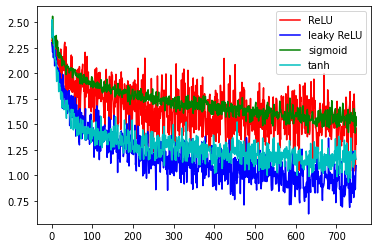

In [29]:
all_csts = []
activation_list = ['ReLU','leaky ReLU','sigmoid','tanh']
for activationi in activation_list:
    modeli = NNeuralnetwork([784,128,10],activation=activationi)
    modeli.train(X_train,Y_train,X_cv,Y_cv,beta1=0.9,beta2=0.99,batch_size=32,epochs=30,show_epochs=False)
    all_csts.append(modeli.return_losses())
cnt=0
print(all_csts[0])
plt.plot(np.arange(30*int(np.ceil(X_train.shape[0]/32))),all_csts[0],label=activation_list[0],c='r')
plt.plot(np.arange(30*int(np.ceil(X_train.shape[0]/32))),all_csts[1],label=activation_list[1],c='b')
plt.plot(np.arange(30*int(np.ceil(X_train.shape[0]/32))),all_csts[2],label=activation_list[2],c='g')
plt.plot(np.arange(30*int(np.ceil(X_train.shape[0]/32))),all_csts[3],label=activation_list[3],c='c')

plt.legend(loc="upper right")

# Testing the model with different architechtures

# Single Hidden Layer model

Epoch 0/100=> 
 loss=2.0056191931220777 accuracy=0.38675 validation accuracy = 0.38066666666666665
Epoch 1/100=> 
 loss=1.6409179351725205 accuracy=0.48304166666666665 validation accuracy = 0.476
Epoch 2/100=> 
 loss=1.6994325274359712 accuracy=0.5937083333333333 validation accuracy = 0.5866666666666667
Epoch 3/100=> 
 loss=1.4724472103208155 accuracy=0.5939583333333334 validation accuracy = 0.587
Epoch 4/100=> 
 loss=1.5128867457337742 accuracy=0.601 validation accuracy = 0.593
Epoch 5/100=> 
 loss=1.2762748896868694 accuracy=0.6089166666666667 validation accuracy = 0.5993333333333334
Epoch 6/100=> 
 loss=1.32276584329477 accuracy=0.61225 validation accuracy = 0.602
Epoch 7/100=> 
 loss=1.4029620675329522 accuracy=0.607 validation accuracy = 0.6006666666666667
Epoch 8/100=> 
 loss=1.1925945489850847 accuracy=0.6160416666666667 validation accuracy = 0.608
Epoch 9/100=> 
 loss=1.3706609885207615 accuracy=0.62025 validation accuracy = 0.612
Epoch 10/100=> 
 loss=1.1921255276388316 accura

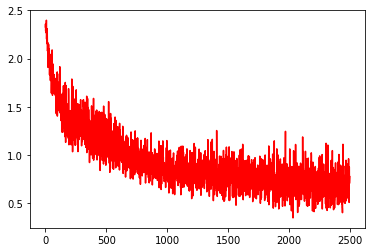

In [24]:
model = NNeuralnetwork([784,128,10],activation='leaky ReLU')
model.train(X_train,Y_train,X_cv,Y_cv,beta1=0.9,beta2=0.99,batch_size=32,epochs=100)

In [25]:
model.accuracy(X_test,Y_test)

0.7916666666666666

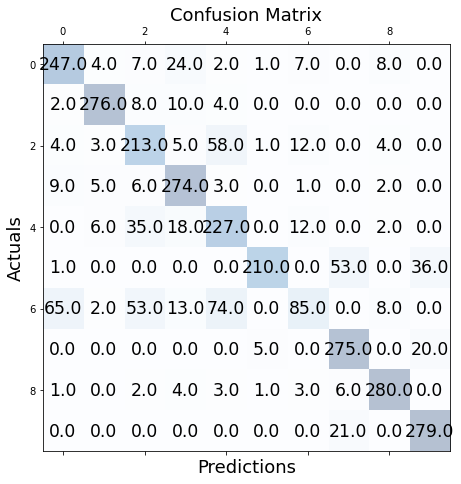

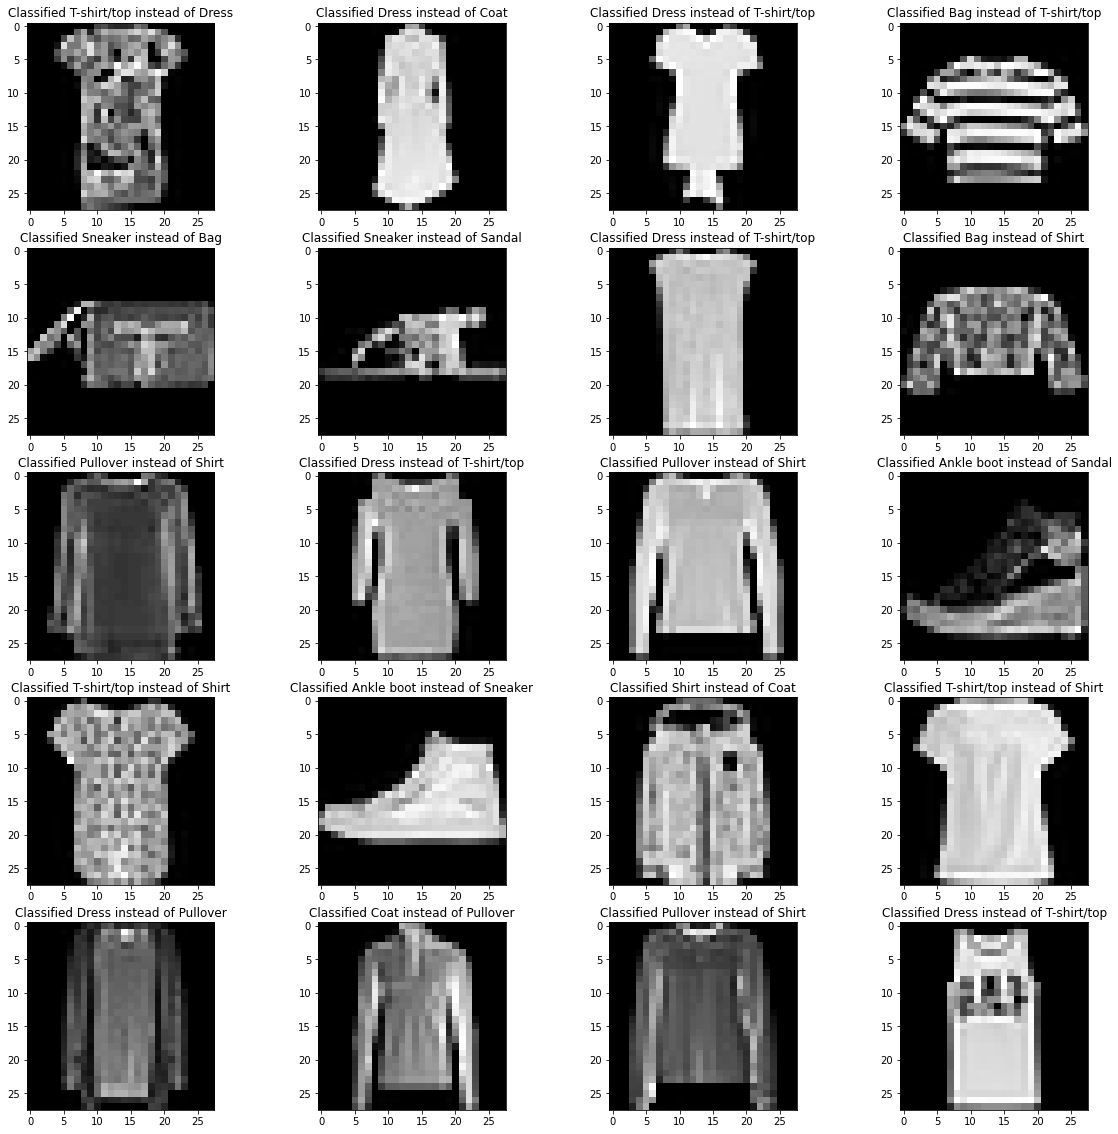

In [26]:
model.complete_test(X_cv,Y_cv)

# **Double Hidden layer neural network**

Epoch 0/100=> 
 loss=2.0992860314199095 accuracy=0.3935416666666667 validation accuracy = 0.388
Epoch 1/100=> 
 loss=2.0151466469091632 accuracy=0.4197916666666667 validation accuracy = 0.41
Epoch 2/100=> 
 loss=1.8206562901935492 accuracy=0.512625 validation accuracy = 0.514
Epoch 3/100=> 
 loss=1.7190009158766393 accuracy=0.5684166666666667 validation accuracy = 0.5633333333333334
Epoch 4/100=> 
 loss=1.6982074048509674 accuracy=0.5746666666666667 validation accuracy = 0.5693333333333334
Epoch 5/100=> 
 loss=1.7883538443012577 accuracy=0.5795833333333333 validation accuracy = 0.5746666666666667
Epoch 6/100=> 
 loss=1.494472828830881 accuracy=0.576375 validation accuracy = 0.5766666666666667
Epoch 7/100=> 
 loss=1.4701322660412703 accuracy=0.585625 validation accuracy = 0.579
Epoch 8/100=> 
 loss=1.4814551895241546 accuracy=0.5858333333333333 validation accuracy = 0.5856666666666667
Epoch 9/100=> 
 loss=1.5888794260881804 accuracy=0.58125 validation accuracy = 0.5776666666666667
Epoch

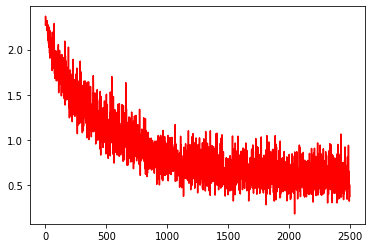

In [ ]:
model1 = NNeuralnetwork([784,128,128,10])
model1.train(X_train,Y_train,X_cv,Y_cv,beta1=0.9,beta2=0.99,epochs=100)

In [ ]:
model1.accuracy(X_cv,Y_cv)

0.8073333333333333

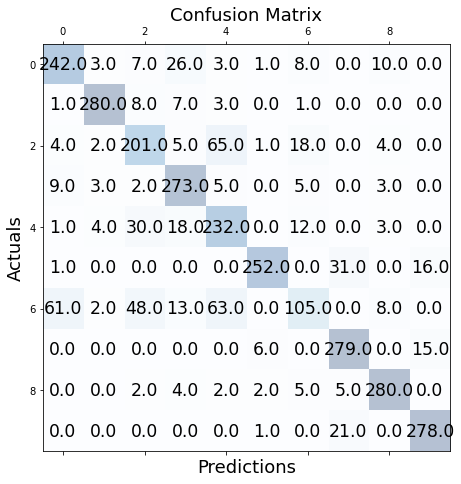

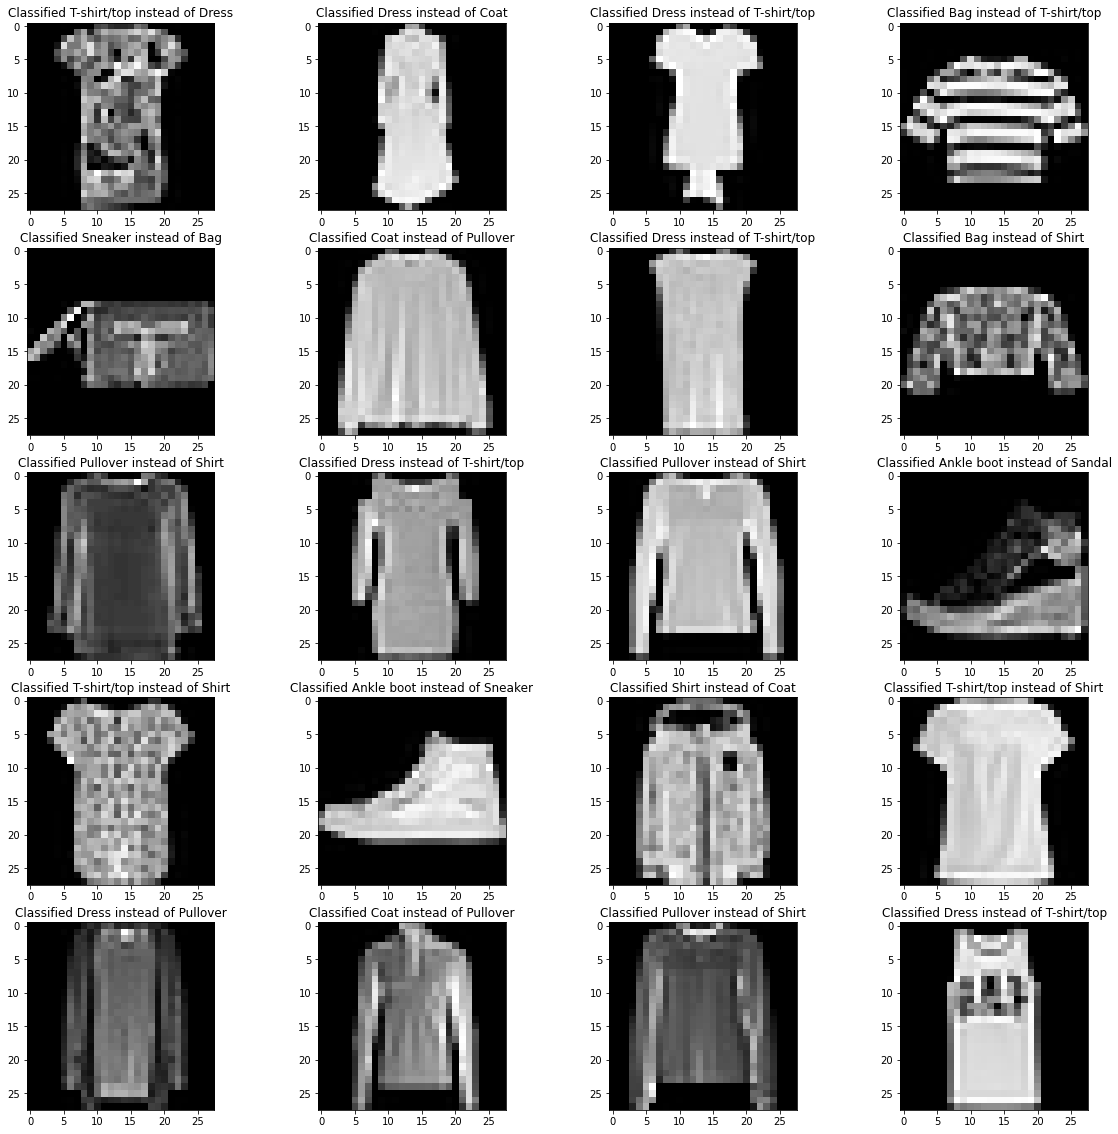

In [ ]:
model1.complete_test(X_cv,Y_cv)

# Three Hidden Layers

Epoch 0/100=> 
 loss=2.02247397560595 accuracy=0.449 validation accuracy = 0.439
Epoch 1/100=> 
 loss=1.8998561029170533 accuracy=0.5176666666666667 validation accuracy = 0.5143333333333333
Epoch 2/100=> 
 loss=1.7036409971589426 accuracy=0.5282083333333333 validation accuracy = 0.5186666666666667
Epoch 3/100=> 
 loss=1.6460905046779613 accuracy=0.5455416666666667 validation accuracy = 0.532
Epoch 4/100=> 
 loss=1.3986459453921234 accuracy=0.5491666666666667 validation accuracy = 0.5436666666666666
Epoch 5/100=> 
 loss=1.533407157265867 accuracy=0.553 validation accuracy = 0.5423333333333333
Epoch 6/100=> 
 loss=1.328601900686069 accuracy=0.5805416666666666 validation accuracy = 0.5733333333333334
Epoch 7/100=> 
 loss=1.3093911618207619 accuracy=0.6219583333333333 validation accuracy = 0.6193333333333333
Epoch 8/100=> 
 loss=1.3179502108608456 accuracy=0.6279583333333333 validation accuracy = 0.6203333333333333
Epoch 9/100=> 
 loss=1.3395315579113942 accuracy=0.627625 validation accura

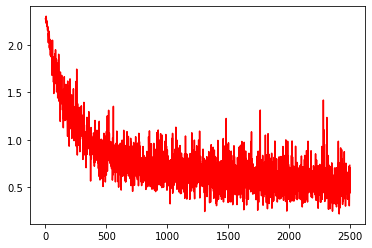

In [ ]:
model3 = NNeuralnetwork([784,256,128,128,10])
model3.train(X_train,Y_train,X_cv,Y_cv,beta1=0.9,beta2=0.99,epochs=100)

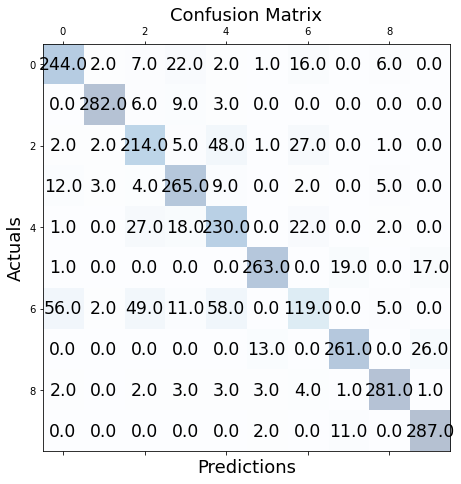

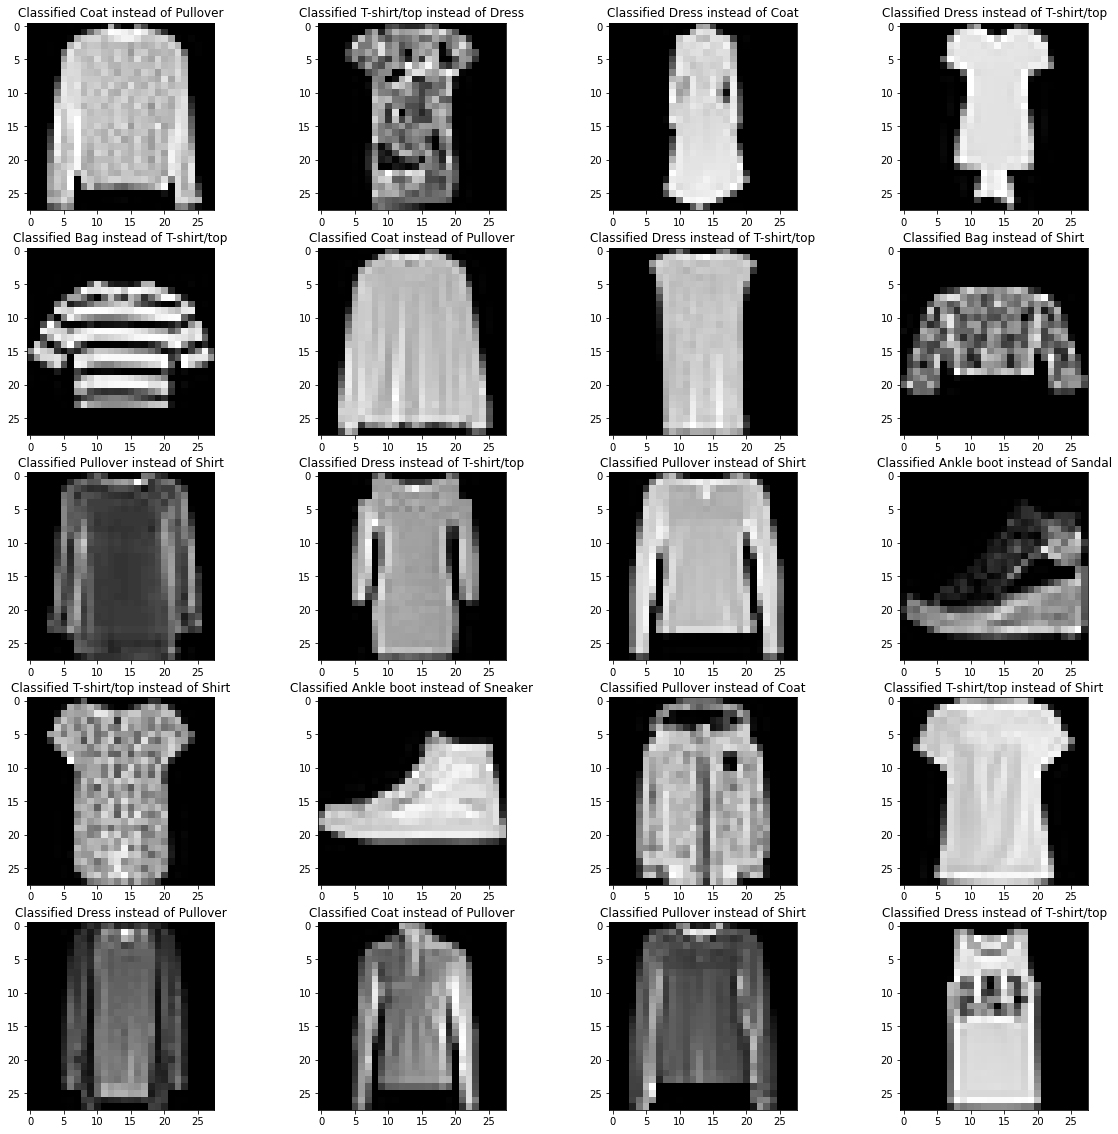

In [ ]:
model3.complete_test(X_cv,Y_cv)

In [ ]:
model3.accuracy(X_cv,Y_cv)

0.8153333333333334

In [ ]:
model3.accuracy(X_test,Y_test)

0.8223333333333334

# Four Hidden Layers

Epoch 0/100=> 
 loss=1.411558615735356 accuracy=0.48354166666666665 validation accuracy = 0.484
Epoch 1/100=> 
 loss=1.032094859615891 accuracy=0.5775416666666666 validation accuracy = 0.5763333333333334
Epoch 2/100=> 
 loss=1.1436880265489462 accuracy=0.6279166666666667 validation accuracy = 0.6206666666666667
Epoch 3/100=> 
 loss=1.0658452206271534 accuracy=0.6696666666666666 validation accuracy = 0.6706666666666666
Epoch 4/100=> 
 loss=0.9886320257856587 accuracy=0.6764583333333334 validation accuracy = 0.6746666666666666
Epoch 5/100=> 
 loss=0.969200854193131 accuracy=0.6745833333333333 validation accuracy = 0.661
Epoch 6/100=> 
 loss=0.5936706045590984 accuracy=0.7474583333333333 validation accuracy = 0.7343333333333333
Epoch 7/100=> 
 loss=0.6323369522946433 accuracy=0.748375 validation accuracy = 0.7386666666666667
Epoch 8/100=> 
 loss=0.6958469516772804 accuracy=0.7617916666666666 validation accuracy = 0.7576666666666667
Epoch 9/100=> 
 loss=0.6417606012457095 accuracy=0.792125

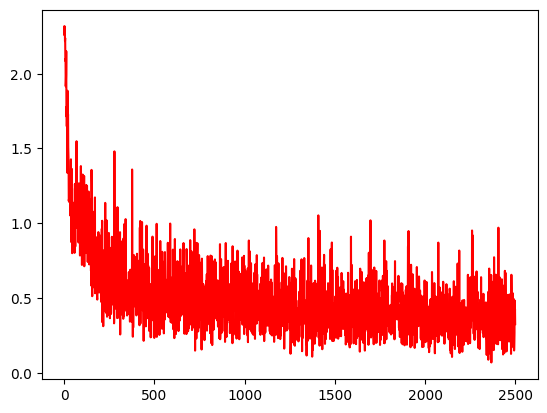

In [12]:
model4 = NNeuralnetwork([784,256,256,128,128,10],activation='leaky ReLU')
model4.train(X_train,Y_train,X_cv,Y_cv,beta1=0.9,beta2=0.99,epochs=100,learning_rate=0.001)

In [9]:
model4.accuracy(X_cv,Y_cv)

0.856

In [13]:
model4.accuracy(X_test,Y_test)

0.8553333333333333

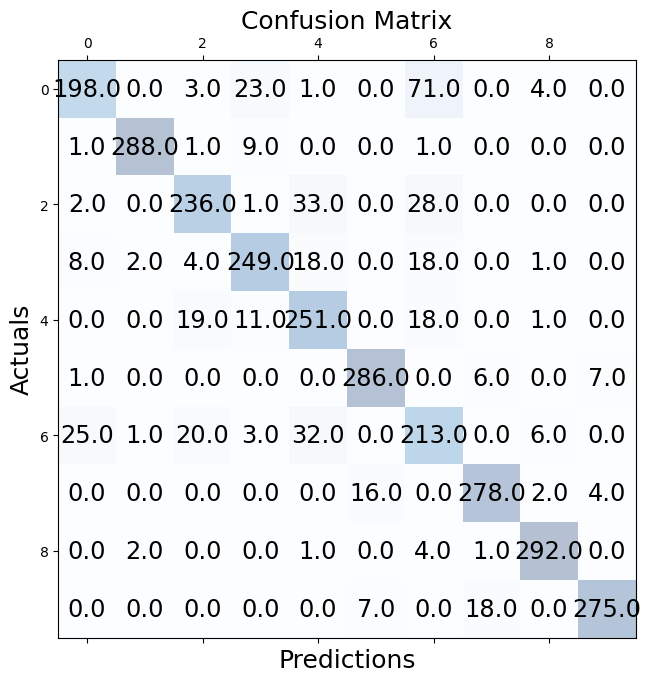

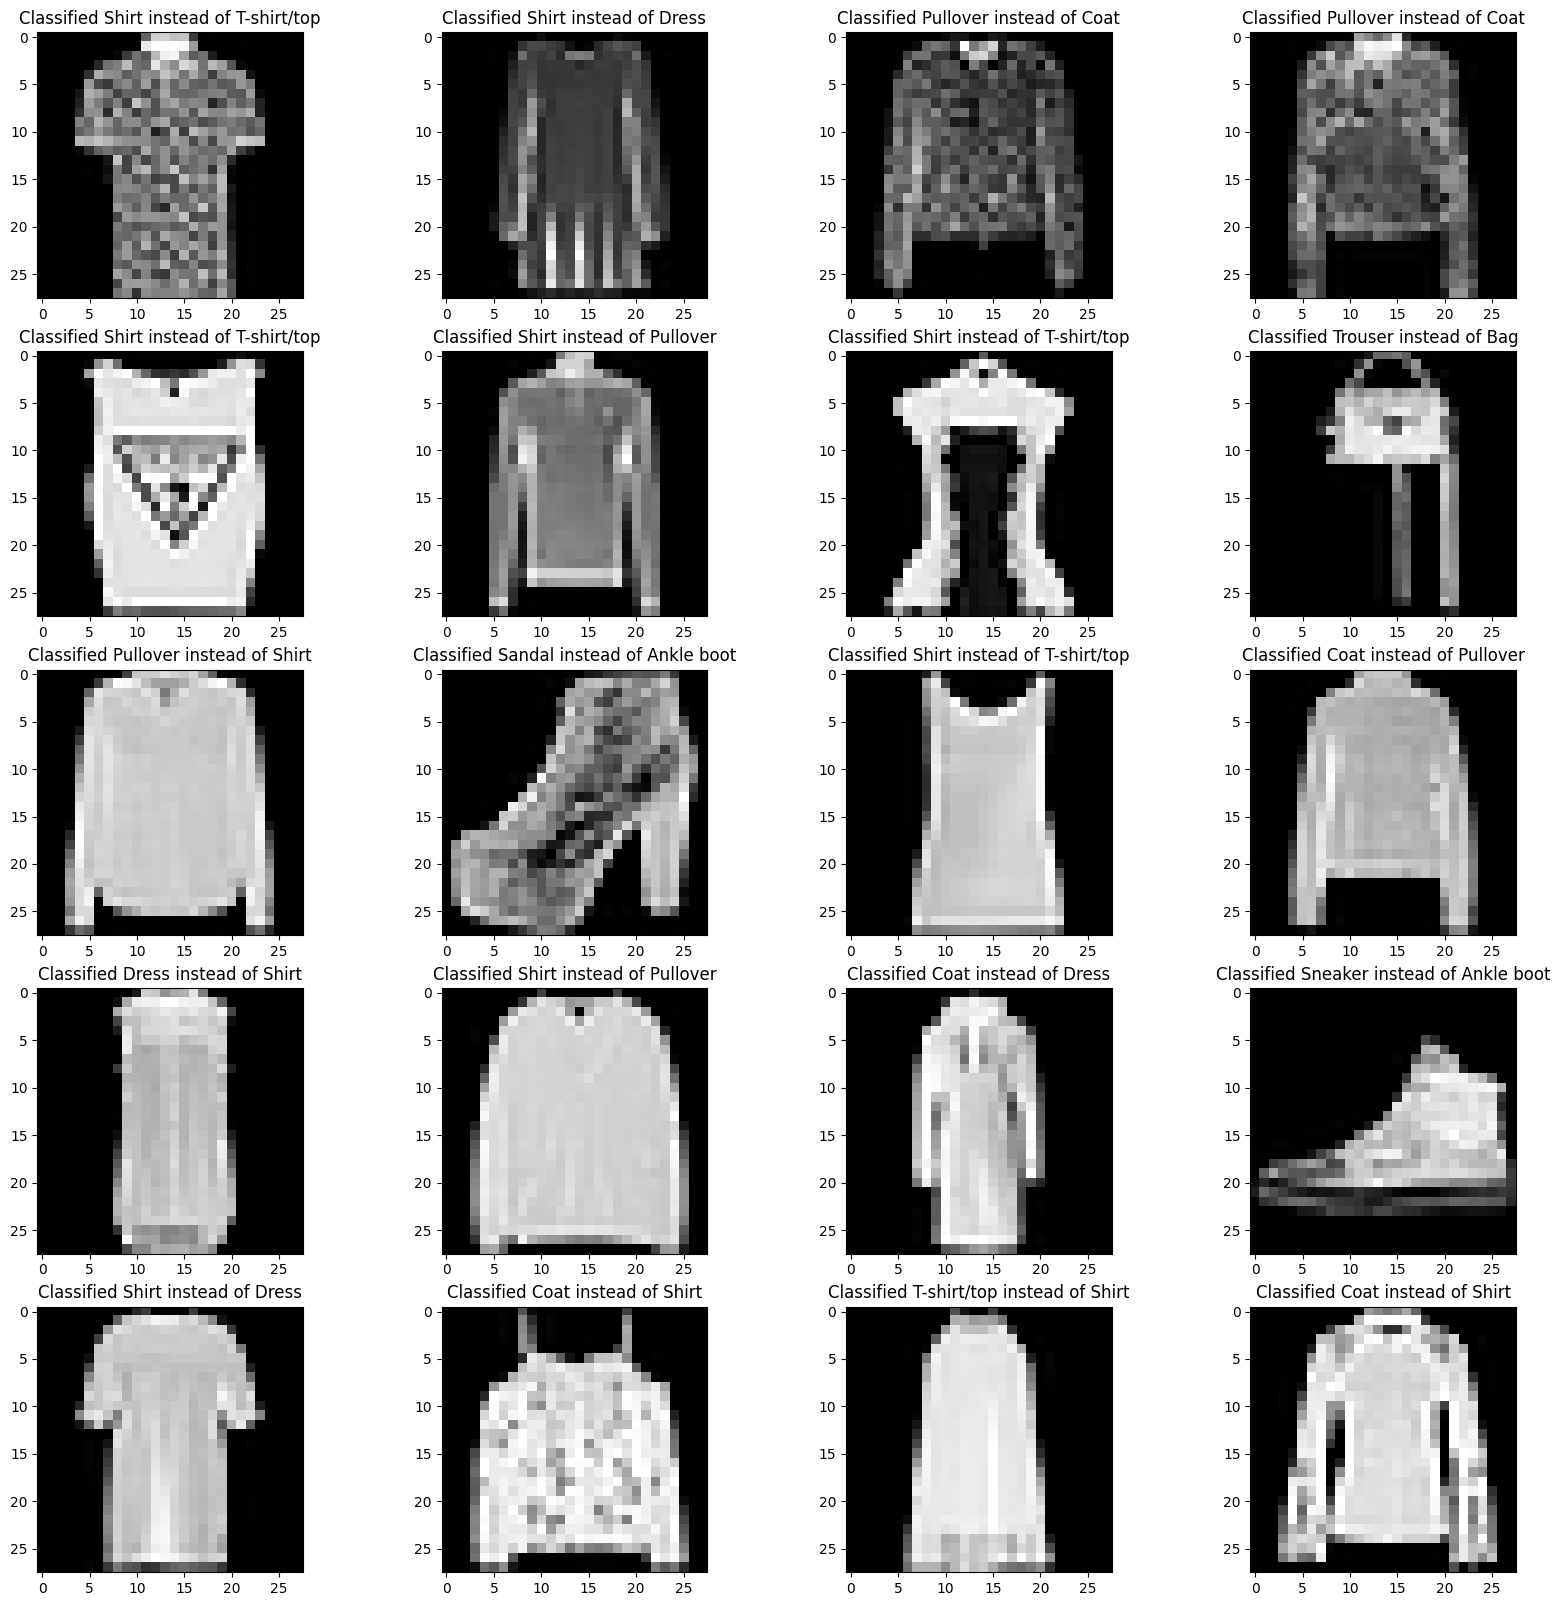

In [14]:
model4.complete_test(X_test,Y_test)

Epoch 0/100=> 
 loss=1.6190260111049328 accuracy=0.435375 validation accuracy = 0.43
Epoch 1/100=> 
 loss=1.5016795771502531 accuracy=0.47458333333333336 validation accuracy = 0.474
Epoch 2/100=> 
 loss=1.202756001606573 accuracy=0.507125 validation accuracy = 0.5076666666666667
Epoch 3/100=> 
 loss=1.084051949369318 accuracy=0.57875 validation accuracy = 0.575
Epoch 4/100=> 
 loss=0.9881069049562233 accuracy=0.6500833333333333 validation accuracy = 0.6493333333333333
Epoch 5/100=> 
 loss=0.7366393604059396 accuracy=0.7185 validation accuracy = 0.72
Epoch 6/100=> 
 loss=0.7114795853814069 accuracy=0.7162916666666667 validation accuracy = 0.714
Epoch 7/100=> 
 loss=0.6664180157701493 accuracy=0.741875 validation accuracy = 0.7376666666666667
Epoch 8/100=> 
 loss=0.5894316004405449 accuracy=0.753 validation accuracy = 0.7466666666666667
Epoch 9/100=> 
 loss=0.8338208114925287 accuracy=0.763 validation accuracy = 0.7576666666666667
Epoch 10/100=> 
 loss=0.7575373486126624 accuracy=0.7525 

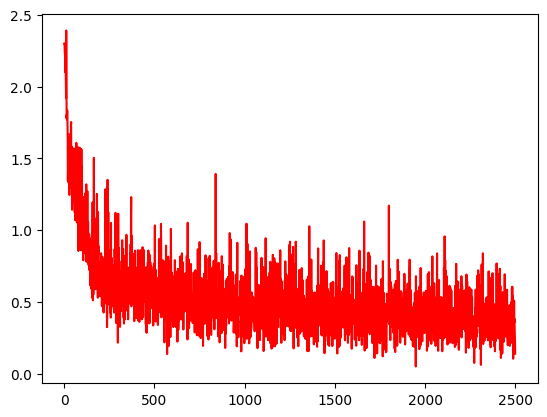

In [10]:
model5 = NNeuralnetwork([784,512,256,128,128,50,50,10],activation='leaky ReLU')
model5.train(X_train,Y_train,X_cv,Y_cv,beta1=0.9,beta2=0.99,epochs=100,learning_rate=0.001)

# 